# Project 01 - Color Compression


## Thông tin sinh viên


- Họ và tên: Nguyễn Lê Hồ Anh Khoa
- MSSV: 23127211
- Lớp: 23CLC09


## Import các thư viện liên quan


In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd


## Helper functions


In [7]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)

    # print(f"Original unique colors: {len(np.unique(img_array.reshape(-1, 3), axis=0))} colors")
    return img_array


def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''

    plt.imshow(img_2d)
    plt.axis("off") 
    plt.show()


def save_img(img_2d, img_path, export_type='png'):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    full_path = f"{img_path}.{export_type}"

    img = Image.fromarray(np.uint8(img_2d))

    img.save(full_path)
    print(f"✅ Image saved at: {full_path}")

def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    h, w, c = img_2d.shape
    return img_2d.reshape((h * w, c))


def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    
    img_1d = img_1d.astype(np.float32)
    num_channels = img_1d.shape[1]
    
    if init_centroids == 'random':
        centroids = set()
        while len(centroids) < k_clusters:
            new_centroid = tuple(np.random.randint(0, 256, size=num_channels))
            centroids.add(new_centroid)
        centroids = np.array(list(centroids), dtype=np.float32)
    else:
        unique_pixels = np.unique(img_1d, axis=0)
        centroids = init_centroids_in_pixels_diverse(unique_pixels, k_clusters).astype(np.float32)

    labels = np.zeros(len(img_1d), dtype=np.int32)
    
    for _ in range(max_iter):
        old_centroids = centroids.copy()

        # Vectorized distance calculation
        diff = img_1d[np.newaxis, :, :] - centroids[:, np.newaxis, :]  # (k, n_pixels, 3)
        distances = np.sum(diff ** 2, axis=2)  # (k, n_pixels)
        labels = np.argmin(distances, axis=0)

        # Update centroids
        for i in range(k_clusters):
            points = img_1d[labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)

        if np.allclose(old_centroids, centroids):
            print(f"Break at iteration {_ + 1} as centroids did not change.")
            break
            
    return centroids, labels

def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    quantized_1d = centroids[labels]
    
    # Reshape back to 2D image
    quantized_2d = quantized_1d.reshape(img_2d_shape)
    
    return quantized_2d.astype(np.uint8)


def init_centroids_in_pixels_diverse(img_1d, k_clusters):
    # Bước 1: Chọn ngẫu nhiên điểm đầu tiên
    unique_pixels = np.unique(img_1d, axis=0)
    centroids = [unique_pixels[np.random.choice(len(unique_pixels))]]

    for _ in range(1, k_clusters):
        # Tính khoảng cách từ mọi điểm đến các centroid đã chọn (tối thiểu trong số đã có)
        dists = np.min(
            np.linalg.norm(img_1d[:, None] - np.array(centroids), axis=2),
            axis=1
        )
        # Xác suất chọn điểm mới tỷ lệ thuận với bình phương khoảng cách
        prob = dists**2
        prob /= prob.sum()

        # Chọn điểm tiếp theo theo xác suất này
        next_idx = np.random.choice(len(img_1d), p=prob)
        centroids.append(img_1d[next_idx])

    return np.array(centroids)


## Your tests


Break at iteration 34 as centroids did not change.
✅ Image saved at: output\test1.jpg_compressed.jpg
Break at iteration 35 as centroids did not change.
✅ Image saved at: output\test2.jpg_compressed.jpg
Break at iteration 22 as centroids did not change.
✅ Image saved at: output\test3.jpg_compressed.jpg
Break at iteration 54 as centroids did not change.
✅ Image saved at: output\test4.jpg_compressed.jpg
Break at iteration 16 as centroids did not change.
✅ Image saved at: output\test5.jpg_compressed.jpg
Break at iteration 24 as centroids did not change.
✅ Image saved at: output\test6.jpg_compressed.jpg
Break at iteration 22 as centroids did not change.
✅ Image saved at: output\test7.jpg_compressed.jpg
Break at iteration 17 as centroids did not change.
✅ Image saved at: output\test8.jpg_compressed.jpg
Break at iteration 31 as centroids did not change.
✅ Image saved at: output\test9.jpg_compressed.jpg
Break at iteration 70 as centroids did not change.
✅ Image saved at: output\test10.jpg_comp

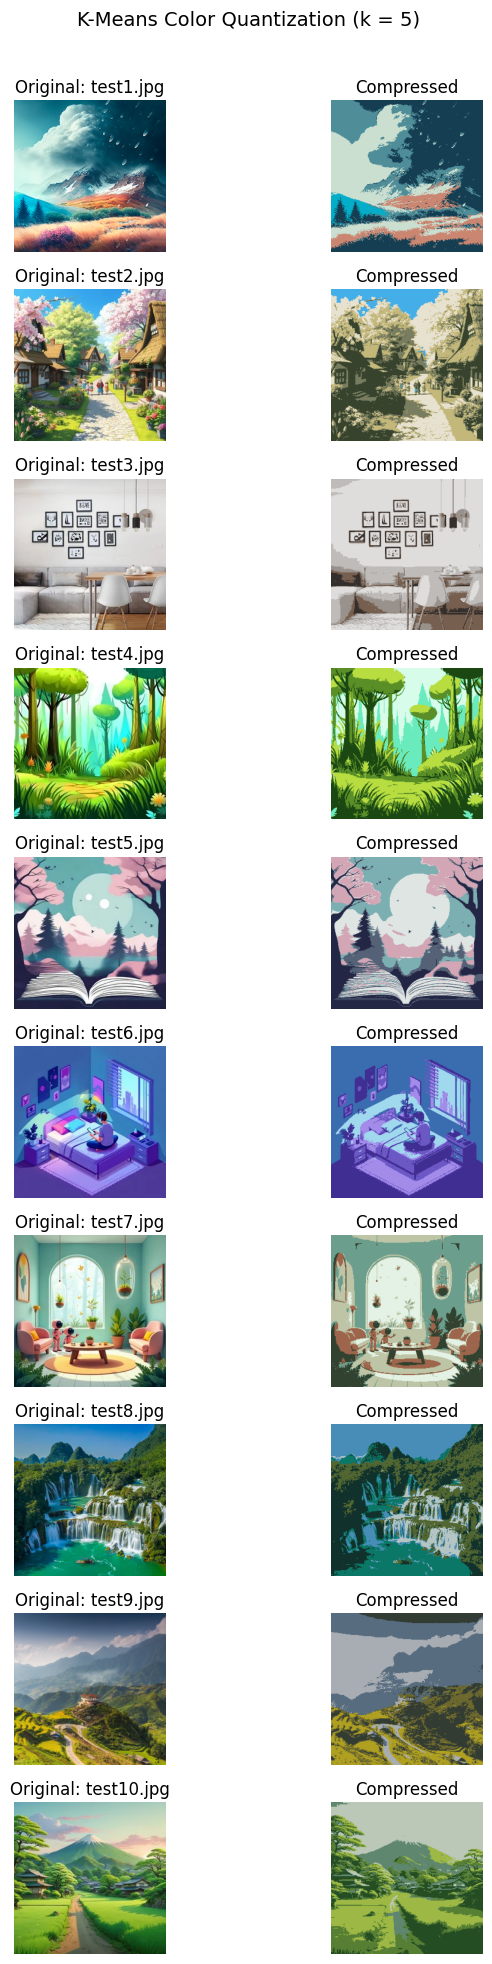

,filename,clusters,max_iter,init_method,time (s),error
0,test1.jpg,5,100,in_pixels,1.03,None
1,test2.jpg,5,100,in_pixels,1.04,None
2,test3.jpg,5,100,in_pixels,0.50,None
3,test4.jpg,5,100,in_pixels,1.25,None
4,test5.jpg,5,100,in_pixels,0.41,None
5,test6.jpg,5,100,in_pixels,0.54,None
6,test7.jpg,5,100,in_pixels,0.53,None
7,test8.jpg,5,100,in_pixels,0.45,None
8,test9.jpg,5,100,in_pixels,0.69,None
9,test10.jpg,5,100,in_pixels,1.51,None


In [26]:
def benchmark_kmeans_on_images(k_clusters=5, max_iter=100, init_method='in_pixels'):
    input_dir = "input"
    image_names = [f"test{i}.jpg" for i in range(1, 11)]
    results = []

    fig, axes = plt.subplots(len(image_names), 2, figsize=(8, len(image_names) * 2))
    fig.suptitle("K-Means Color Quantization (k = {})".format(k_clusters), fontsize=14)

    for idx, filename in enumerate(image_names):
        input_path = os.path.join(input_dir, filename)
        try:
            img_2d = read_img(input_path)
            img_1d = convert_img_to_1d(img_2d)

            start = time.time()
            centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_method)
            duration = time.time() - start

            quantized_img = generate_2d_img(img_2d.shape, centroids, labels)
            save_img(quantized_img, os.path.join("output", f"{filename}_compressed"), export_type='jpg')

            # Lưu kết quả
            results.append({
                "filename": filename,
                "clusters": k_clusters,
                "max_iter": max_iter,
                "init_method": init_method,
                "time (s)": round(duration, 2),
                "error": None
            })

            axes[idx, 0].imshow(img_2d)
            axes[idx, 0].set_title(f"Original: {filename}")
            axes[idx, 1].imshow(quantized_img)
            axes[idx, 1].set_title("Compressed")

            for ax in axes[idx]:
                ax.axis("off")

        except Exception as e:
            results.append({
                "filename": filename,
                "clusters": k_clusters,
                "time (s)": None,
                "error": str(e)
            })

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    df = pd.DataFrame(results)
    return df

df = benchmark_kmeans_on_images(k_clusters=5, max_iter=100, init_method='in_pixels')
df


## Main FUNCTION


In [ ]:
def main():
    img_name = input("Enter the photo filename in folder input (e.g., test2.jpg): ").strip()
    # img_name = 'test2.jpg' 
    img_input_path = f"input/{img_name}"

    img_2d = read_img(img_input_path)

    print("🖼️ Original photo:")
    show_img(img_2d)

    img_1d = convert_img_to_1d(img_2d)

    # k_clusters = int(input("Enter number of colors (clusters): "))
    k_clusters = 5  
    # max_iter = int(input("Enter max iterations for K-Means: "))
    # init_method = input("Choose centroid init method ('random' or 'in_pixels'): ").strip()

    max_iter = 300
    init_method = 'in_pixels'  # 'random' or 'in_pixels'

    start_time = time.time()
    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_method)
    end_time = time.time()
    print(f"⏱️ K-Means completed in {end_time - start_time:.2f} seconds with {k_clusters} clusters.")

    new_img_2d = generate_2d_img(img_2d.shape, centroids, labels)

    print(f"🎨 Photo after reducing color to {k_clusters} colors:")
    show_img(new_img_2d)

    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)

    base_name = os.path.basename(img_input_path).rsplit('.', 1)[0]
    output_path = os.path.join(output_folder, f"{base_name}_compressed")
    
    valid_formats = {'jpg', 'JPG', 'jpeg', 'JPEG', 'png', 'PNG', 'pdf', 'PDF'}
    # export_type = input("Enter file format to save (jpg, png, pdf): ").strip().lower()
    export_type = 'JPG'
    
    if export_type not in valid_formats:
        print("❌ Invalid file format. Allowed: jpg, png, pdf.")
        return
    
    save_img(new_img_2d, output_path, export_type)


🖼️ Original photo:


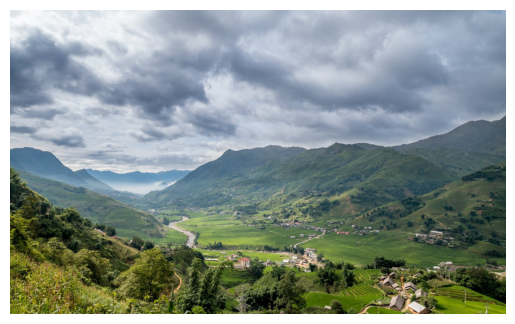

Break at iteration 221 as centroids did not change.
⏱️ K-Means completed in 155.73 seconds with 5 clusters.
🎨Photo after reducing color to 5 colors:


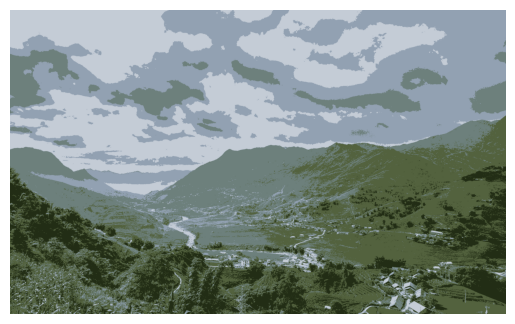

✅ Image saved at: output\test2_compressed.JPG


In [15]:
if __name__ == "__main__":
	main()


# Nhận xét

- Chất lượng ảnh, có gần giống ảnh gốc không
- Độ đo
- Tốc độ chạy
